In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maitram22","key":"32fb23d1d46cbf2be1906420c95b0d32"}'}

In [6]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘.kaggle’: File exists


In [7]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

In [9]:
! kaggle datasets download -d thomasdubail/screwanomalies-detection

 95% 177M/187M [00:02<00:00, 84.6MB/s]
100% 187M/187M [00:02<00:00, 85.1MB/s]


In [14]:
!cp screwanomalies-detection.zip 'drive/My Drive/TIES4911/task8/'

In [1]:
!unzip -q 'drive/My Drive/TIES4911/task8/screwanomalies-detection.zip' -d 'drive/My Drive/TIES4911/task8/dataset/screwanomalies-detection/'

In [6]:
! pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.1 MB/s eta 0:00:00


In [2]:
! pip install tensorflow_docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.6/183.6 kB 4.5 MB/s eta 0:00:00


In [7]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [10]:
batch_size= 24
image_size = [128, 128]


ds = image_dataset_from_directory(
    'drive/My Drive/TIES4911/task8/dataset/screwanomalies-detection/screw/train',
    labels=None,
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
)

def convert_to_float(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image


def trans1(img):
    return tfa.image.rotate(tf.image.flip_left_right(tf.image.flip_up_down(img)),-.2,fill_mode="reflect",interpolation="bilinear")

def trans2(img):
    return tfa.image.rotate(img,-.2,fill_mode="reflect",interpolation="bilinear")

def trans3(img):
    return tfa.image.rotate(img,.2,fill_mode="reflect",interpolation="bilinear")
    
ds1,ds2,ds3,ds4 = ds,ds.map(trans1),ds.map(trans2),ds.map(trans3)

ds = ds1.concatenate(ds2).concatenate(ds3).concatenate(ds4)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = (
    ds
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 320 files belonging to 1 classes.


In [11]:
ds_a = image_dataset_from_directory(
    'drive/My Drive/TIES4911/task8/dataset/screwanomalies-detection/screw/test/scratch_neck',
    labels=None,
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
)
print(type(ds))

def convert_to_float(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image

AUTOTUNE = tf.data.experimental.AUTOTUNE
test_dataset = (
    ds_a
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 25 files belonging to 1 classes.
<class 'tensorflow.python.data.ops.concatenate_op._ConcatenateDataset'>


In [12]:
a,b = image_size
shape=(a, b, 3)

class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=shape),
            tf.keras.layers.Conv2D(filters=64, kernel_size=2, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(filters=128, kernel_size=2, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(filters=256, kernel_size=2, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=8*8*64, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(8, 8, 64)),
            tf.keras.layers.Conv2DTranspose(
                filters=256, kernel_size=2, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=2, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=2, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=2, strides=2, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    print(mean.shape)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [79]:
latent_dim = 32

encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=shape),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )
encoder.summary()

decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=8*8*64, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(8, 8, 64)),
            tf.keras.layers.Conv2DTranspose(
                filters=256, kernel_size=2, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=2, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=2, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=2, strides=2, padding='same'),
        ]
    )
decoder.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 63, 63, 32)        896       
                                                                 
 conv2d_51 (Conv2D)          (None, 31, 31, 64)        18496     
                                                                 
 flatten_25 (Flatten)        (None, 61504)             0         
                                                                 
 dense_50 (Dense)            (None, 64)                3936320   
                                                                 
Total params: 3,955,712
Trainable params: 3,955,712
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)   

In [18]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  print(z.shape)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [13]:
epochs = 30
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 32
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [15]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [16]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 30, Test set ELBO: -26358.509765625, time elapse for current epoch: 35.54720640182495


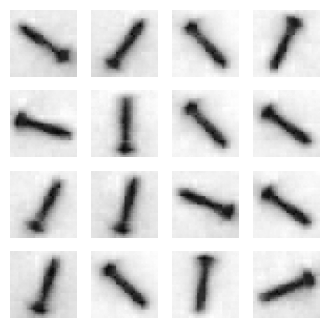

In [99]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

Epoch: 1, Test set ELBO: -27857.935546875, time elapse for current epoch: 44.90346646308899
(16, 32)


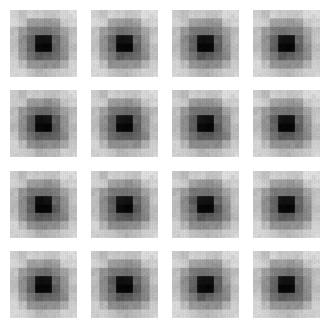

In [19]:
generate_and_save_images(model, 0, test_sample)
epochs = 1
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

In [4]:
anim_file = 'drive/My Drive/TIES4911/task8/cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

NameError: ignored

In [8]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

Output hidden; open in https://colab.research.google.com to view.